# Explore GeMAPS
Use this code to find out how the features of the GeMAPS feature set are extracted

Most of the logic for this Notebook is hidden in the class "Custom_GeMAPS"

In [1]:
# Imports
# Python packages
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Custom package
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "src"))
from age_by_voice.audio.custom_gemaps import Custom_GeMAPS, GeMAPS_Settings

# Load an audiofile
Load an audiofile into the Custom_GeMAPS class.
Its best to use a Wave file.
You can customize the samplerate.

When the file is found the class has the sample_rate (sr) and the array of samples (y).

In [2]:
audio_path: str = "../data/awed5130.wav"

# play the audio
ipd.Audio(filename=audio_path, autoplay=True)

In [3]:
custom_ge = Custom_GeMAPS(audio_path=audio_path, sample_rate=16000)

custom_ge.sr

/home/chr1s/Dokumente/github/Programming/Python/Age_by_Voice/src/age_by_voice/audio/custom_gemaps.py:77: UserWarning: With fmin=27.000, sr=16000 and frame_length=960, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=33.333 or frame_length=1187.
  self._f0, self._f0_voiced_flag, self._f0_prob = librosa.pyin(


16000

Text(0, 0.5, 'Amplitude')

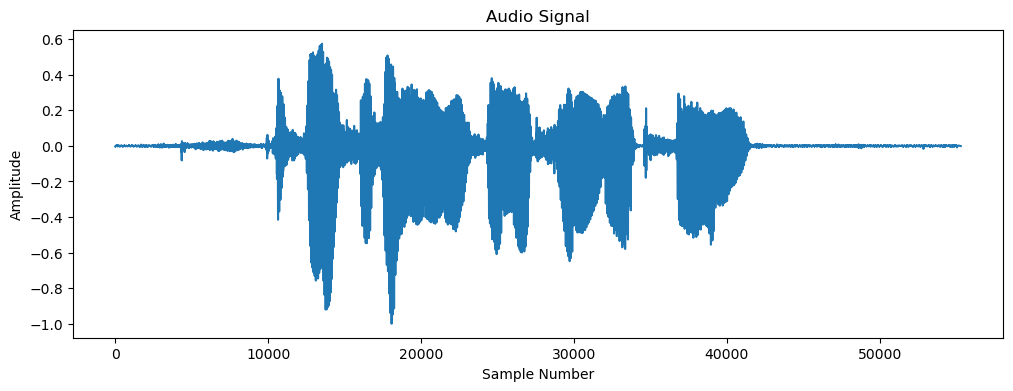

In [4]:
# Plot the samples
plt.figure(figsize=(12, 4))
plt.plot(custom_ge.y)

plt.title("Audio Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

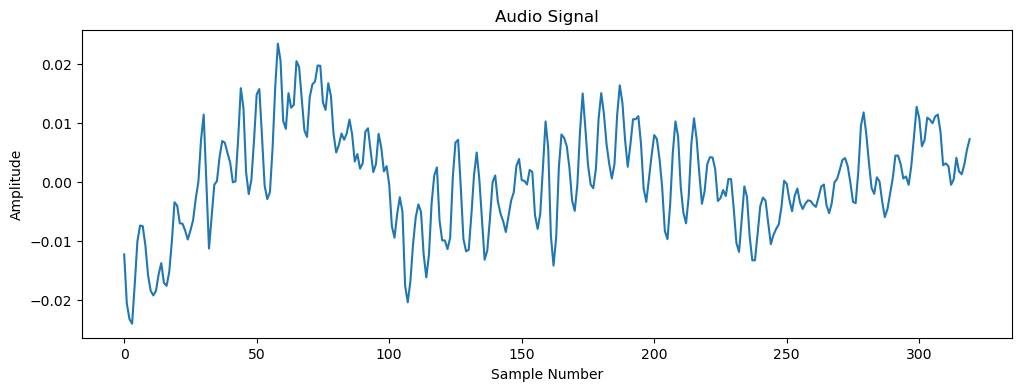

In [5]:
# Plot a short timeframe of the audio signal 
plt.figure(figsize=(12, 4))
length = 0.02 # lenghth of the timeframe in seconds
offset = 0.5 # offset in seconds
time_start = int(custom_ge.sr * offset)
time_end = time_start + int(custom_ge.sr * length)
plt.plot(custom_ge.y[time_start:time_end])

plt.title("Audio Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")

# Time Domain Features
We can also extract time domain features from the audio signal.

In [6]:
# Loudness
loudness = custom_ge.loudness()

print(f"Mean Loudness: {loudness.loudness_mean}, Standard Deviation Loudness: {loudness.loudness_std}")
print(f"25: {loudness.loudness_25}, 80: {loudness.loudness_80}, 90: {loudness.loudness_90}")

Mean Loudness: -23.970464920951677, Standard Deviation Loudness: 16.909130671411596
25: -43.11686102549235, 80: -6.799043337504068, 90: -5.675124963124593


In [7]:
# Zero Crossing Rate
zcr = custom_ge.zero_crossing_rate()

print(f"Mean ZCR: {zcr.zcr_mean}, Standard Deviation ZCR: {zcr.zcr_std}")

Mean ZCR: 0.09243637604367373, Standard Deviation ZCR: 0.10130408026197432


In [8]:
# Peaks per Second
pps = custom_ge.peaks_per_second()

print(f"Mean Pps: {pps.pps_mean}, Standard Deviation Pps: {pps.pps_std}")
print(f"25: {pps.pps_25}, 80: {pps.pps_80}, 90: {pps.pps_90}")

Mean Pps: 1048.6772486772488, Standard Deviation Pps: 827.4909628731883
25: 526.3888888888889, 80: 1488.8888888888891, 90: 2083.333333333333


# Into the Frequency domain!
Visualize the audio file in the frequency domain using the spectrogram function of the Custom_GeMAPS class.

In [9]:
# F0
f0 = custom_ge.f0()

print(f"Mean F0: {f0.f0_mean}, Standard Deviation F0: {f0.f0_std}")
print(f"Min F0: {f0.f0_min}, Max F0: {f0.f0_max}")
print(f"25: {f0.f0_25}, 80: {f0.f0_80}, 90: {f0.f0_90}")

Mean F0: 184.96393251639475, Standard Deviation F0: 37.60954244976665
Min F0: 79.97926782347446, Max F0: 253.91834775725948
25: 173.43327132144492, 80: 213.11194343495262, 90: 222.6732284303293


In [10]:
# HNR
hnr = custom_ge.harmonics_to_noice_ratio()

print(f"Mean HNR: {hnr.hnr_mean}, Standard Deviation HNR: {hnr.hnr_std}")

Mean HNR: 12.546541849772135, Standard Deviation HNR: 0.0


In [11]:
# Additional features
additional_features = custom_ge.additional_spectral_features()

print(f"Mean Spectral Centroid: {additional_features.spectral_centroid_mean}, Standard Deviation Spectral Centroid: {additional_features.spectral_centroid_std}")
print(f"Mean Spectral Bandwidth: {additional_features.spectral_bandwidth_mean}, Standard Deviation Spectral Bandwidth: {additional_features.spectral_bandwidth_std}")
print(f"Mean Spectral Flatness: {additional_features.spectral_flatness_mean}, Standard Deviation Spectral Flatness: {additional_features.spectral_flatness_std}")
print(f"Mean Spectral Rolloff: {additional_features.spectral_rolloff_mean}, Standard Deviation Spectral Rolloff: {additional_features.spectral_rolloff_std}")

Mean Spectral Centroid: 1076.0322701246073, Standard Deviation Spectral Centroid: 600.6046792811991
Mean Spectral Bandwidth: 1315.852042331714, Standard Deviation Spectral Bandwidth: 375.01050541287617
Mean Spectral Flatness: -59.18629902096816, Standard Deviation Spectral Flatness: 16.68034069885493
Mean Spectral Rolloff: 1985.6361542890038, Standard Deviation Spectral Rolloff: 1260.1745346948085


# Quefrency Features
The quefrency features are extracted from the cepstrum of the audio signal.

In [12]:
# MFCC Bands
mfcc_1_4 = custom_ge.mfcc_1_4()

print(f"Mean MFCC 1: {mfcc_1_4.mfcc_1_mean}, Standard Deviation MFCC 1: {mfcc_1_4.mfcc_1_std}")
print(f"Mean MFCC 2: {mfcc_1_4.mfcc_2_mean}, Standard Deviation MFCC 2: {mfcc_1_4.mfcc_2_std}")
print(f"Mean MFCC 3: {mfcc_1_4.mfcc_3_mean}, Standard Deviation MFCC 3: {mfcc_1_4.mfcc_3_std}")
print(f"Mean MFCC 4: {mfcc_1_4.mfcc_4_mean}, Standard Deviation MFCC 4: {mfcc_1_4.mfcc_4_std}")

Mean MFCC 1: -39.45879431215592, Standard Deviation MFCC 1: 4.640893849818208
Mean MFCC 2: 6.42628494134118, Standard Deviation MFCC 2: 2.4891081971080085
Mean MFCC 3: -0.001860265242054866, Standard Deviation MFCC 3: 1.5214357424374738
Mean MFCC 4: 1.2182940944405158, Standard Deviation MFCC 4: 1.6090719541364913


In [ ]:
all_features = custom_ge.custom_gemaps(clip_id="hehe")

Time taken to extract all features: 0.019176721572875977 seconds


In [17]:
all_features

Custom_GeMAPS_Features(mfcc_1_mean=-39.45879431215592, mfcc_1_std=4.640893849818208, mfcc_2_mean=6.42628494134118, mfcc_2_std=2.4891081971080085, mfcc_3_mean=-0.001860265242054866, mfcc_3_std=1.5214357424374738, mfcc_4_mean=1.2182940944405158, mfcc_4_std=1.6090719541364913, spectral_centroid_mean=1076.0322701246073, spectral_centroid_std=600.6046792811991, spectral_bandwidth_mean=1315.852042331714, spectral_bandwidth_std=375.01050541287617, spectral_flatness_mean=-59.18629902096816, spectral_flatness_std=16.68034069885493, spectral_rolloff_mean=1985.6361542890038, spectral_rolloff_std=1260.1745346948085, f0_mean=184.96393251639475, f0_std=37.60954244976665, f0_25=173.43327132144492, f0_80=213.11194343495262, f0_90=222.6732284303293, f0_min=79.97926782347446, f0_max=253.91834775725948, hnr_mean=12.546541849772135, hnr_std=0.0, pps_mean=1048.6772486772488, pps_std=827.4909628731883, pps_25=526.3888888888889, pps_80=1488.8888888888891, pps_90=2083.333333333333, zcr_mean=0.0924363760436737